# Challenge 6

### Likelihood study with binned Poisson data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from numba import jit

np.random.seed(
    0
)  # We manually set the seed for reproducible results, this is not required

energies = np.arange(10) + 0.5  # bin centers
print(f"energies: {energies}")

counts = np.array([9, 6, 16, 11, 18, 7, 8, 7, 8, 10])
print(f"counts: {counts}")

energies: [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
counts: [ 9  6 16 11 18  7  8  7  8 10]


We use numba to speed up the execution

In [2]:
@jit
def model(E, S, B, E_0=4, sigma_E=1):
    return B + S * np.exp(-((E - E_0) ** 2) / (2 * sigma_E ** 2))

In [3]:
@jit
def log_likelihood(bin_centers, counts, S, B):
    result = 0
    for i in range(len(counts)):
        # Poisson bins
        mu = model(bin_centers[i], S=S, B=B)
        result += 2 * (mu - counts[i] + counts[i] * np.log(counts[i] / mu))
    return result

## Fit data

In [4]:
@jit
def minimize_loglike(bins, counts, N=100):
    S_result = 0
    B_result = 0

    log_min = 1e10

    for S in np.linspace(0.01, 20, N):
        for B in np.linspace(0, 20, N):
            loglike = log_likelihood(energies, counts, S=S, B=B)
            if loglike < log_min:
                log_min = loglike
                S_result = S
                B_result = B

    return log_min, S_result, B_result


log_min_ref, S_result_ref, B_result_ref = minimize_loglike(energies, counts, N=500)

print(f"S={S_result_ref:0.3f}, B={B_result_ref:0.3f}, logmin={log_min_ref:0.3f}")

S=7.702, B=8.056, logmin=6.971


S=7.68, B=8.08, L_min=6.970


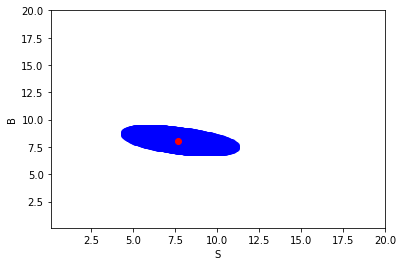

In [5]:
N = 500
S_range = np.linspace(0.1, 20, N)
B_range = np.linspace(0.1, 20, N)
loglike = np.zeros([N, N])
for i, S in enumerate(S_range):
    for j, B in enumerate(B_range):
        loglike[i, j] = log_likelihood(energies, counts, S=S, B=B)

# find the position of the min
loglike_min = np.min(loglike)
S_index, B_index = np.unravel_index(np.argmin(loglike, axis=None), loglike.shape)
S_result = S_range[S_index]
B_result = B_range[B_index]

print(f"S={S_result:0.2f}, B={B_result:0.2f}, L_min={loglike_min:0.3f}")


# CI
indices_inside_CI = []
for i, S in enumerate(S_range):
    for j, B in enumerate(B_range):
        if loglike[i, j] <= loglike_min + 1:
            indices_inside_CI.append((i, j))

S_CI = np.zeros(len(indices_inside_CI))
B_CI = np.zeros(len(indices_inside_CI))
for i, indices in enumerate(indices_inside_CI):
    S_CI[i] = S_range[indices[0]]
    B_CI[i] = B_range[indices[1]]

plt.scatter(S_CI, B_CI, color="blue", alpha=0.5)
plt.scatter([S_result], [B_result], color="red")

plt.xlim([min(S_range), max(S_range)])
plt.ylim([min(B_range), max(B_range)])

plt.xlabel("S")
plt.ylabel("B")

plt.show()

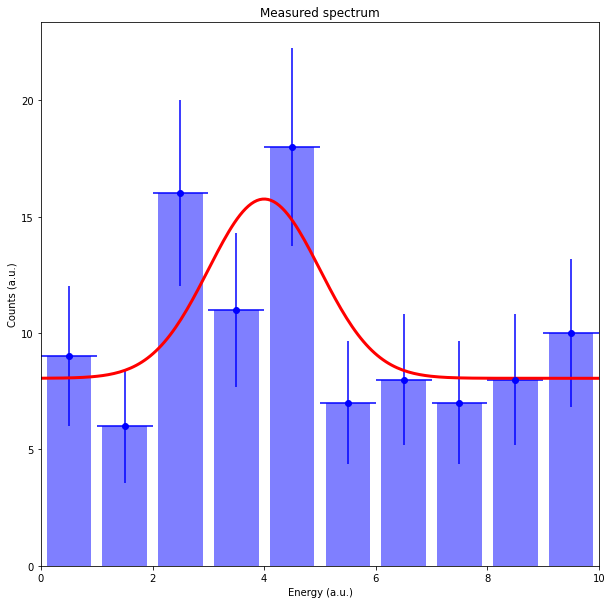

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([0, 10])

ax.set_xlabel("Energy (a.u.)")
ax.set_ylabel("Counts (a.u.)")
ax.set_title("Measured spectrum")

ax.errorbar(energies, counts, xerr=0.5, fmt="o", yerr=np.sqrt(counts), color="blue")

ax.bar(energies, counts, color="blue", alpha=0.5)

x = np.linspace(0, 10, 200)
ax.plot(x, model(x, S=S_result_ref, B=B_result_ref), color="red", linewidth=3)

plt.show()

## MC study to study distribution

In [7]:
import sys

number_of_samples = 10000

log_min_dist = np.zeros(number_of_samples)

for k in range(number_of_samples):
    if k % int(number_of_samples / 10) == 0:
        print(str(k / number_of_samples * 100) + "%")
    sys.stdout.flush()  # to avoid warning due to numba

    sample = [model(energy, S=S_result_ref, B=B_result_ref) for energy in energies]
    sample = np.array([st.poisson(int(count)).rvs() for count in sample])

    # minimize
    N = 100
    S_range = np.linspace(0.1, 20, N)
    B_range = np.linspace(0.1, 20, N)
    loglike = np.zeros([N, N])
    for i, S in enumerate(S_range):
        for j, B in enumerate(B_range):
            loglike[i, j] = log_likelihood(energies, sample, S=S, B=B)

    log_min_dist[k] = np.min(loglike)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


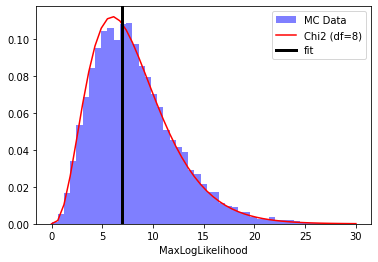

p-value = 0.54


In [8]:
bins = np.linspace(0, 30, 50)

plt.hist(
    log_min_dist, bins=bins, color="blue", alpha=0.5, density=True, label="MC Data"
)
plt.plot(bins, st.chi2(df=10 - 2).pdf(bins), label="Chi2 (df=8)", color="red")
plt.axvline(x=log_min_ref, color="black", linewidth=3, label="fit")
plt.legend()

plt.xlabel("MaxLogLikelihood")
plt.show()

print(f"p-value = {1 - st.chi2(df=10 - 2).cdf(log_min_ref):0.2f}")